# 1. Setup

In [1]:
!pwd

/home/umni2/a/umnilab/users/verma99/mk/spr_4711/code


In [2]:
from mobilkit.umni import *
from project import *

In [3]:
import requests

# 2. ACS

## 2.1. Explore fields

### 2.1.1. Download fields

In [4]:
def get_acs_fields(year: int, five_year=True, table_type='B',
                   exclude_derivative_tables=True,
                   exclude_quality_vars=True,
                   exclude_detailed_tables=True,
                   save=True, overwrite=False):
    assert year <= 2021
    assert table_type in [None, 'B', 'C']
    outpath = Path(f'../data/acs/acs{year % 2000}_fields.csv')
    if outpath.exists() and not overwrite:
        return pd.read_csv(outpath).set_index('fid')
    product = 'acs5' if five_year else 'acs1'
    url = f'https://api.census.gov/data/{year}/acs/{product}/variables'
    resp = requests.get(url)
    if resp.status_code != 200:
        raise ValueError('Could not fetch data: status code={}'
                        .format(resp.status_code))
    df = Pdf(resp.json()[4:], columns=['fid', 'fname', 'tname']).dropna()
    df = df[df.fid.str[0].isin(['B', 'C'])].dropna(subset='tname')
    df.fname = (df.fname.str.lower()
                .str.replace('!!', '__')
                .str.replace(':', '')
                .str.replace('estimate__', ''))
    df.tname = (df.tname.str.lower()
                .str.replace('in the past 12 months', 'last year')
                .str.replace('in the past year', 'last year')
                .str.replace(' years and over', '+ yr')
                .str.replace(f'in {year} inflation-adjusted dollars', 'in IA$'))
    df['tid'] = df.fid.str.split('_').str[0]
    df['fnum'] = df.fid.str.split('_').str[1].str[:-1]
    # filter only the given base tables
    if table_type:
        df = df[df.tid.str[0] == table_type]
    # remove derivative tables (that have suffixes in their IDs)
    if exclude_derivative_tables:
        df = df[df.tid.str[1:].str.isdigit()]
    # remove tables related to survey data quality
    if exclude_quality_vars:
        df = df[df.tid.str[1:3] <= '90']
    # remove detailed tables (they contain way too many variables!)
    if exclude_detailed_tables:
        df = df[~df.tname.str.startswith('detailed')]
    df = df.set_index('fid').sort_index()
    if save:
        df.to_csv(U.mkfile(outpath))
    return df
    
# cols19 = get_acs_fields(year=2019, overwrite=1).disp(3)
cols19 = get_acs_fields(year=2019, overwrite=0).disp(3)

13,624 rows x 4 cols; Memory: 5.1 MiB


,fname,tname,tid,fnum
fid,<object>,<object>,<object>,<int64>
B01001_001E,total,sex by age,B01001,1
B01001_002E,total__male,sex by age,B01001,2
B01001_003E,total__male__under 5 years,sex by age,B01001,3


### 2.1.2. Create field tree
Write a YAML file from the indents of the columns.
This may not always work since the input data indent structure could be flawed (e.g., in table B02016).

In [5]:
def make_field_tree(year: int, outfile='../data/acs/acs{}_field_tree.yaml'):
    cols = pd.read_csv(f'../data/acs/acs{year % 2000}_fields.csv')
    cols['indent'] = cols.fname.str.split('__').str.len()
    cols['leaf'] = list(cols.indent.diff()[1:] <= 0) + [True]
    res = []
    for (tid, tname), df in cols.groupby(['tid', 'tname']):
        res.append(f'<{tid}> {tname}:')
        for _, r in df.iterrows():
            pfx = '  ' * r.indent + f'- <{r.fnum}>'
            name = r.fname.split('__')[-1]
            sfx = '' if r.leaf else ':'
            res.append(f'{pfx} {name}{sfx}')
    with open(outfile.format(year % 2000), 'w') as f:
        f.write('\n'.join(res))

make_field_tree(2019)

### 2.1.3. Define fields of interest

In [6]:
acs_cols = (
    ## _Overall
    'B01001_001E', # total population
    'B19001_001E', # total households
    ## Age
    'B06001_002E', # population in the US aged ≤4 y
    'B16004_002E', # population of minors (aged 5-17 y)
    'B16004_046E', # population of seniors (aged ≥65 y)
    'B01002_001E', # median age of the entire population
    ## Commute mode
    'B08301_001E', # total workers aged ≥16 y
    'B08301_010E', # workers commuting by public transit
    'B08301_018E', # workers commuting by bicycle
    'B08301_019E', # workers commuting by walking
    'B08301_021E', # workers having worked from home
    ## Disability status
    'B18135_001E', # total civilian noninstitutionalized population
    'B18135_002E', # with a disability, under 19 years
    'B18135_013E', # with a disability, 19 to 64 years
    'B18135_025E', # with a disability, 65 years and over
    'B22010_001E', # total households ## same as B19001_001E?
    'B22010_003E', # households with ≥1 disabled person(s), received food stamps
    'B22010_006E', # households with ≥1 disabled person(s), did not receive food stamps
    ## Education
    'B15003_001E', # total population aged ≥25 y
    'B15003_021E', # eligible population with associate's degree
    'B15003_022E', # eligible population with bachelor's degree
    'B15003_023E', # eligible population with master's degree
    'B15003_024E', # eligible population with professional school degree
    'B15003_025E', # eligible population with doctorate degree
    ## Employment
    'B23025_002E', # population of labor force (aged ≥16 y)
    'B23025_005E', # unemployed population in labor force
    ## Family
    'B11012_003E', # married-couple households with children
    'B11012_006E', # cohabiting-couple households with children
    'B11012_010E', # single-mother households
    'B11012_015E', # single-father households
    ## Health insurance
    'B27010_001E', # total civilian noninstitutionalized population
    'B27010_017E', # eligible population with no coverage, aged ≤19 y
    'B27010_033E', # eligible population with no coverage, aged 19-34 y
    'B27010_050E', # eligible population with no coverage, aged 35-64 y
    'B27010_066E', # eligible population with no coverage, aged ≥65 y
    ## Housing
    'B25033_001E', # total population in occupied housing units
    'B25033_008E', # total population in renter-occupied housing units
    'B25033_006E', # total population in owner-occupied mobile home housing units
    'B25033_013E', # total population in renter-occupied mobile home housing units
    'B26103_001E', # total population ## same as B00001_001E?
    'B25014_001E', # total housing units
    'B25014_005E', # owner-occupied units, (1, 1.5] occupants per room
    'B25014_006E', # owner-occupied units, (1.5, 2] occupants per room
    'B25014_007E', # owner-occupied units, >2 occupants per room
    'B25014_0011E', # renter-occupied units, (1, 1.5] occupants per room
    'B25014_0012E', # renter-occupied units, (1.5, 2] occupants per room
    'B25014_0013E', # renter-occupied units, >2 occupants per room
    ## Income & poverty
    'B19301_001E', # median household income (inflation-adjusted USD)
    'B17021_001E', # total population for whom poverty status is determined
    'B17021_002E', # eligible population with income less than poverty level
    'B17026_001E', # total families
    'B17026_002E', # families with income < 0.5 * poverty level
    'B17026_003E', # income ÷ poverty level in [0.5, .75)
    'B17026_004E', # income ÷ poverty level in [0.75, 1)
    'B17026_005E', # income ÷ poverty level in [1, 1.25)
    'B17026_006E', # income ÷ poverty level in [1.25, 1.5)
    'B22010_002E', # total households having received food stamps/SNAP last year
    ## Language
    'B16004_001E', # total population aged ≥5 y
    *[f'B16004_{x:03}E' for x in (7,8,12,13,17,18,22,23,29,30,34,35,39,40,44,45,51,52,56,57,61,62,66,67)],
    ## Race
    'B02001_002E', # total White population
    'B02001_003E', # total Black population
    ## Vehicle ownership
    'B25044_001E', # total occupied housing units
    'B25044_003E', # owner-occupied housing units with no vehicle available
    'B25044_010E', # renter-occupied housing units with no vehicle available
    'B25046_001E', # aggregate number of vehicles available
)

## 2.2. Prepare data

### 2.2.1. Define derived features

In [7]:
get_acs_ses = lambda x: dict(
    ## Overall
    popu = x.B01001_001E,
    hh = x.B19001_001E,
    ## Age
    # median age of population
    m_age = x.B01002_001E,
    # proportion of popu aged ≤18 y
    p_minor = x.B16004_002E / x.B01001_001E,
    # proportion of popu aged ≥64 y
    p_senior = x.B16004_046E / x.B01001_001E,
    ## Race
    # proportion people of color (non-White)
    p_nonwhite = 1 - x.B02001_002E / x.B01001_001E,
    # proportion Black people
    p_black = x.B02001_003E / x.B01001_001E,
    ## Education
    # proportion people not having a college degree
    p_nocollege = 1 - (x.B15003_021E + x.B15003_022E + x.B15003_023E + x.B15003_024E + x.B15003_025E) / x.B15003_001E,
    ## Income & poverty
    # per capita income in the last year (inflation-adjusted USD)
    m_income = x.B19301_001E,
    # proportion of eligible population below poverty level
    p_pov = x.B17021_002E / x.B17021_001E,
    # proportion of families with income < 0.5 times poverty level
    p_pov50 = x.B17026_002E / x.B17026_001E,
    # proportion of families with income between 0.5 to 1.5 times poverty level
    p_pov150 = (x.B17026_003E + x.B17026_004E + x.B17026_005E + x.B17026_006E) / x.B17026_001E,
    # proportion of households having received food stamps/SNAP last year
    p_snap = x.B22010_002E / x.B19001_001E,
    ## Employment
    # proportion of labor force unemployed
    p_unemploy = x.B23025_005E / x.B23025_002E,
    ## Health & disability
    # proportion of population without health insurance
    p_noinsurance = (x.B27010_017E + x.B27010_033E + x.B27010_050E + x.B27010_066E) / x.B27010_001E,
    # proportion of eligible population with a disability, including
    # difficulty in hearing, vision, cognition, self-car, indendent living, ambulation
    p_disabled = (x.B22010_003E + x.B22010_006E) / x.B22010_001E,
    ## Language
    # proportion of population in limited English-speaking households
    p_lowenglish = pd.concat([x[f'B16004_{i:03}E'] for i in (7, 8, 12, 13, 17, 18, 22, 23, 29, 30, 34, 35, 39, 40, 44, 45, 51, 52, 56, 57, 61, 62, 66, 67)], axis=1).sum(1) / x.B16004_001E,
    ## Family
    # proportion of households with children that are led by single parents
    p_singleparent = (x.B11012_010E + x.B11012_015E) / (x.B11012_003E + x.B11012_006E + x.B11012_010E + x.B11012_015E),
    ## Housing
    # proportion of housing units occupied by renters
    p_renter = x.B25033_008E / x.B25033_001E,
    # proportion of occupied housing units that are mobile homes
    p_mobilehome = (x.B25033_006E + x.B25033_013E) / x.B25033_001E,
    # proportion of population living in institutionalized group quarters
    # p_grpquarter = x.B26103_003E / x.B26103_001E,
    p_crowded = (x.B25014_005E + x.B25014_006E + x.B25014_007E + x.B25014_0011E + x.B25014_0012E + x.B25014_0013E) / x.B25014_001E,
    ## Transport
    # proportion of households not owning any vehicle
    p_noveh = (x.B25044_003E + x.B25044_010E) / x.B25044_001E,
    # mean no. of vehicles in a household
    m_vehperhh = x.B25046_001E / x.B25044_001E,
    # proportion of non-commuting workers (working from home)
    p_wfh = x.B08301_021E / x.B08301_001E,
    # proportion of commuting workers using public transit
    p_transit = x.B08301_010E / (x.B08301_001E - x.B08301_021E),
    # proportion of commuting workers using alternate modes (not using cars)
    p_altmode = (x.B08301_010E + x.B08301_018E + x.B08301_019E) / (x.B08301_001E - x.B08301_021E),
)

### 2.2.2. Download and process fields

In [8]:
zones = gpd.read_parquet('../data/zones/zones_2010.parquet').set_crs(CRS_DEG).disp()

6,417 rows x 6 cols; Memory: 1.4 MiB; CRS: EPSG:4326


,geoid,name,aland,awater,geometry,scale
,<object>,<object>,<int64>,<int64>,<geometry>,<object>
0,18083,Knox,1336514262,20755159,"POLYGON ((-87.506221 38.733533, -87.506172 38....",COUNTY


In [9]:
def download_acs(scales, zones, year=2019, state='18',
                 fields=acs_cols, outpath='../data/acs/acs{}.csv',
                 save=True, overwrite=False):
    outpath = Path(outpath.format(year % 2000))
    if outpath.exists() and not overwrite:
        return pd.read_csv(outpath)
    if isinstance(fields, str): fields = [fields]
    res = []
    for scale in scales:
        geos = [('state', f'{state:02}')] + D(
            COUNTY=[('county', '*')],
            TRACT=[('county', '*'), ('tract', '*')],
            BG=[('county', '*'), ('tract', '*'), ('block group', '*')]
        )[scale.upper()]
        df = mk.acs.download(geos, fields, year=year)
        # return df
        df = df.reorder_levels([x[0] for x in geos])
        df = Pdf(get_acs_ses(df))
        df.insert(0, 'geoid', df.index.map(''.join))
        df.insert(0, 'scale', scale)
        if 'popu' in df:
            df = df[df['popu'] > 0]
        res.append(df)
    df = pd.concat(res).reset_index(drop=1)
    df = df.merge(zones[['geoid', 'aland']], on='geoid')
    df.insert(4, 'pop_density', df.popu / (df.pop('aland') * U.SQM2SQMI))
    if save:
        df.to_csv(U.mkfile(outpath), index=False)
    return df

# cols = [f'{x}_001E' for x in cols19[cols19.fname.str.contains('occupants per room')].tid.unique()]
# cols = [f'B25014_{i:03}E' for i in range(3, 8)]
# x = download_acs(('BG',), zones, fields=cols, overwrite=1); x # t=0:15
acs = download_acs(SCALES, zones, overwrite=0).disp(2) # t=0:15

6,407 rows x 28 cols; Memory: 1.7 MiB


,scale,geoid,popu,hh,pop_density,m_age,p_minor,p_senior,p_nonwhite,p_black,p_nocollege,m_income,p_pov,p_pov50,p_pov150,p_snap,p_unemploy,p_noinsurance,p_disabled,p_lowenglish,p_singleparent,p_renter,p_mobilehome,p_noveh,m_vehperhh,p_wfh,p_transit,p_altmode
,<object>,<int64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>
0,COUNTY,18069,36359.0,14742.0,95.01872,40.7,0.159328,0.168541,0.041503,0.009819,0.703345,26502.0,0.109009,0.014131,0.133239,0.084588,0.027811,0.078407,0.268824,0.003963,0.192825,0.23065,0.020586,0.047144,1.982024,0.033737,0.001419,0.033155
1,COUNTY,18181,24149.0,9879.0,47.808007,42.0,0.172264,0.195081,0.090853,0.005093,0.742556,27461.0,0.092349,0.036591,0.115062,0.077235,0.03943,0.094821,0.31572,0.019551,0.147356,0.208781,0.025201,0.02895,2.024699,0.041773,0.00238,0.021702


# 3. Visualize

## 3.1. Distributions

## 3.2. Correlations

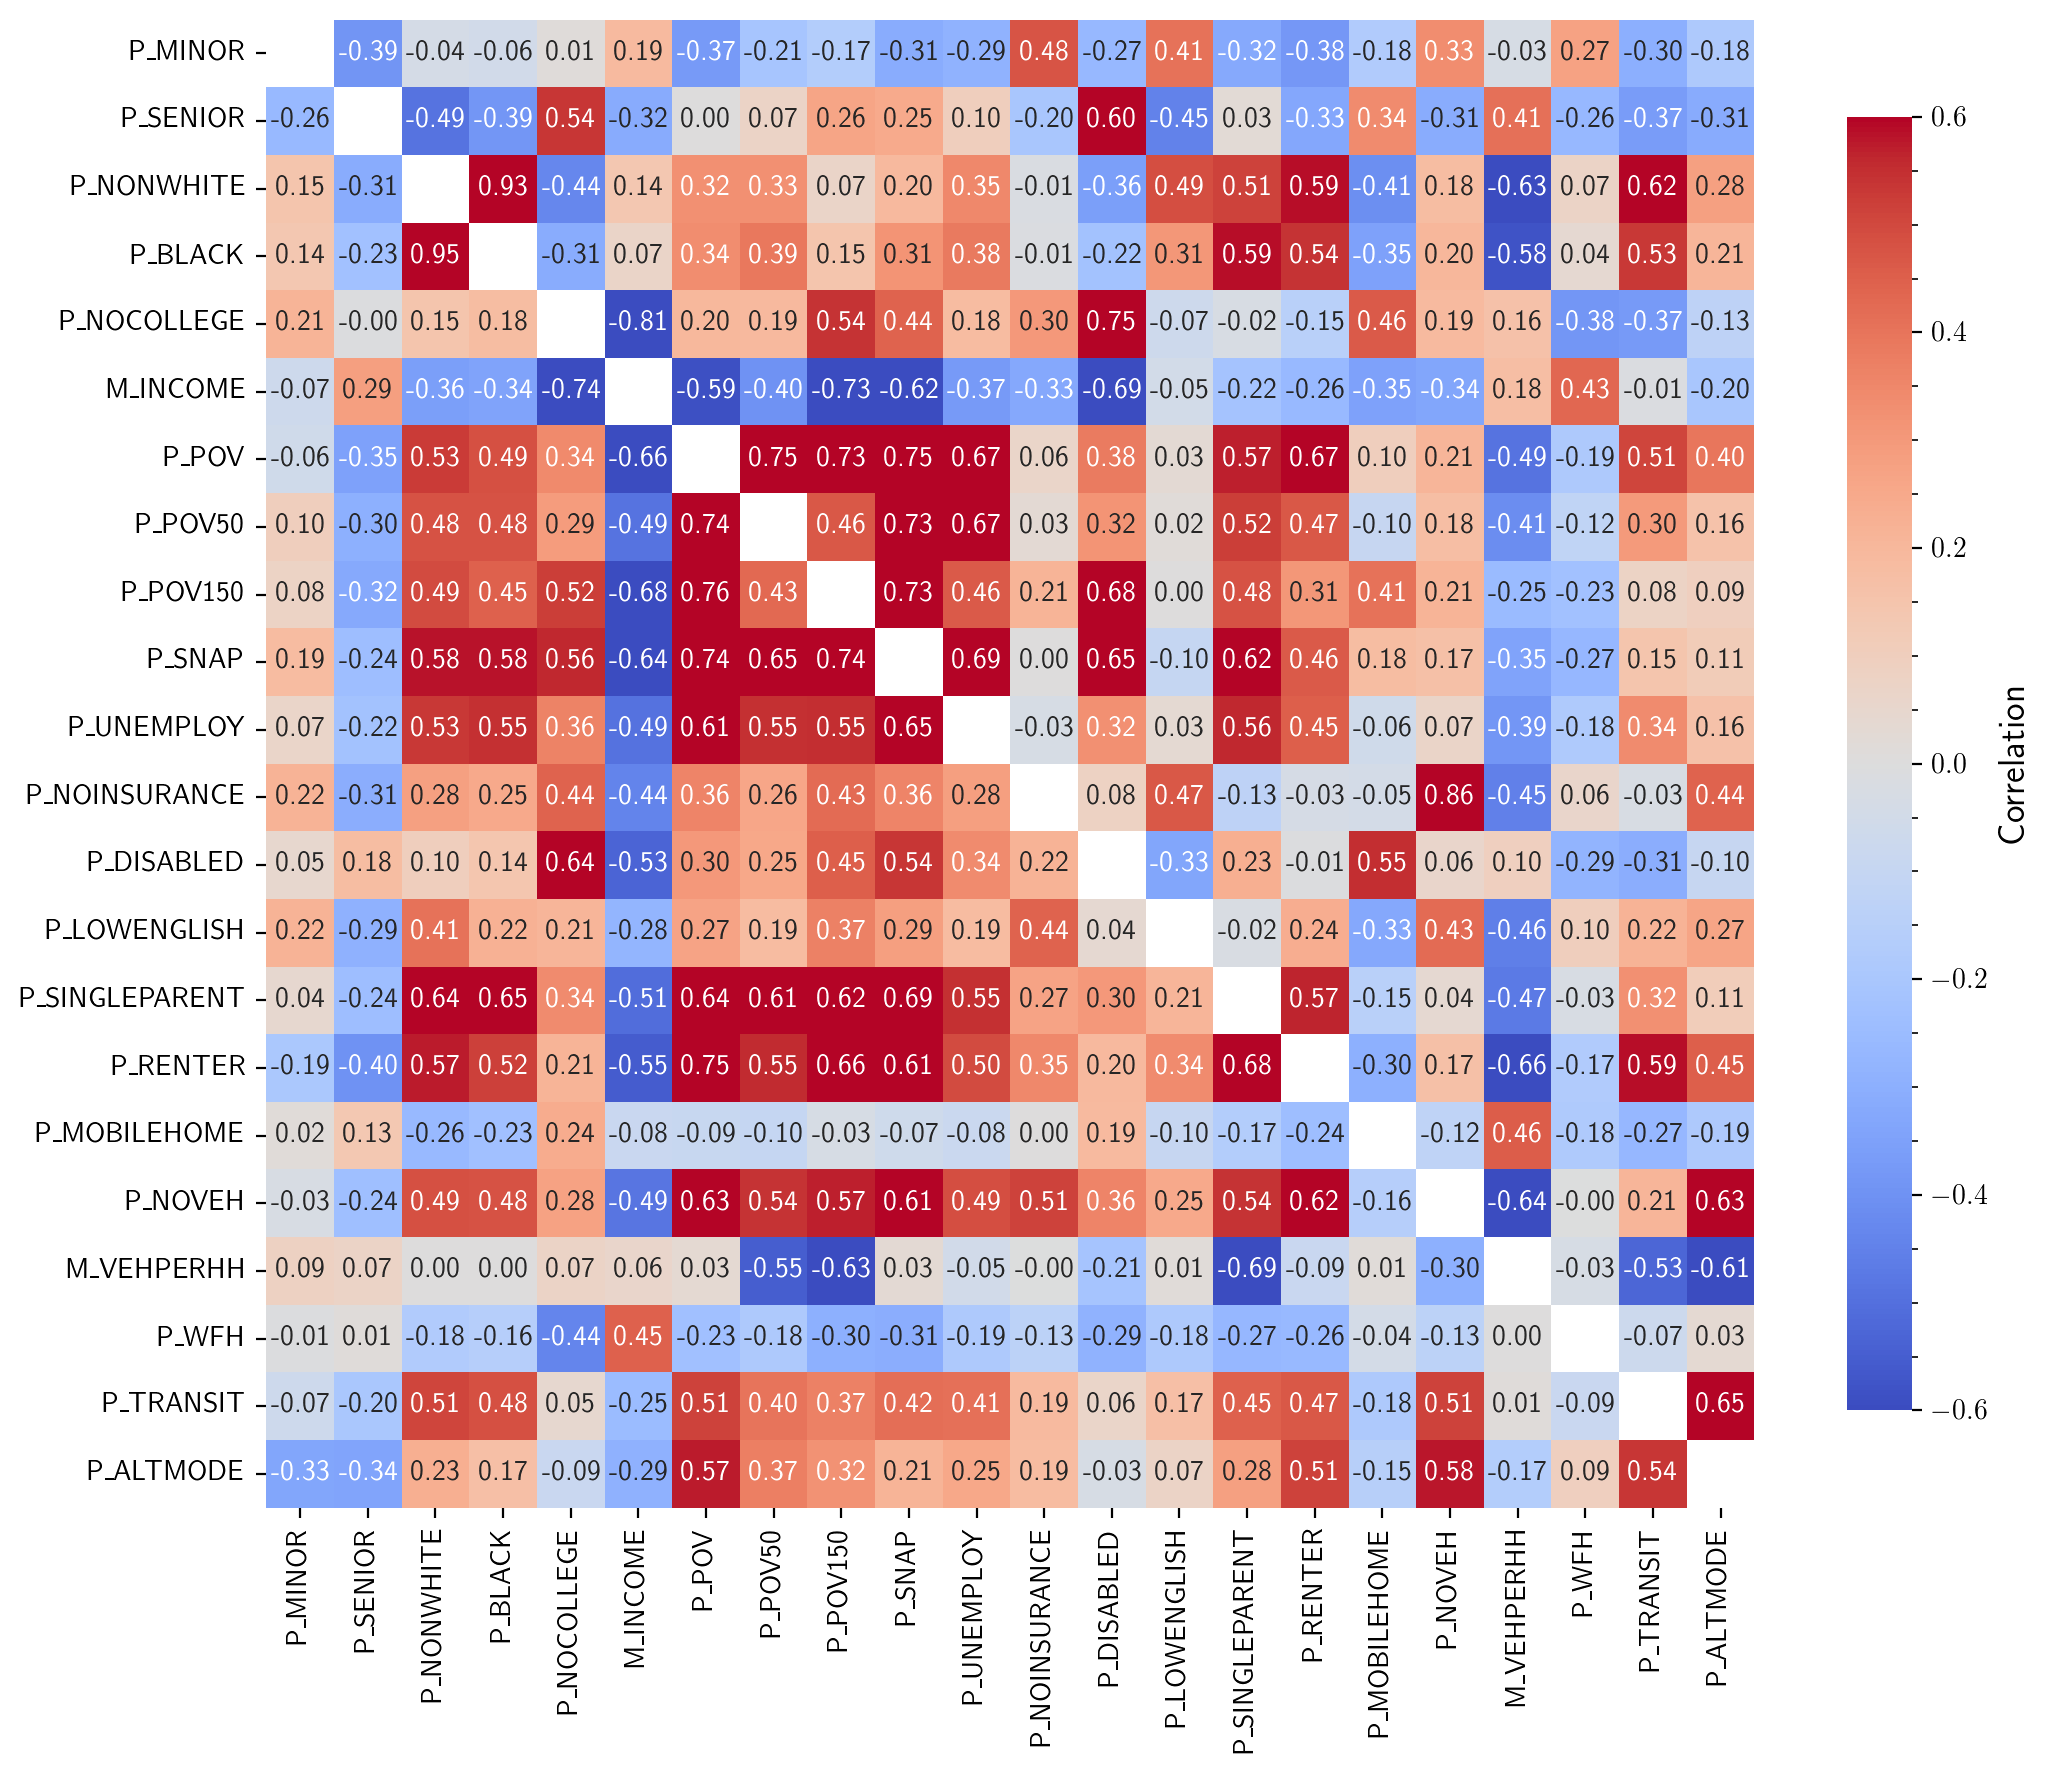

In [45]:
ax = U.plot(size=(12, 12), dpi=200); ax.grid(alpha=0); ax.minorticks_off()
df = acs.set_index('scale').rename(columns=str.upper).iloc[:, 5:]
corr = np.triu(df.loc['COUNTY', :].corr(), 1) + np.tril(df.loc['TRACT', :].corr(), -1)
corr = Pdf(corr, index=df.columns, columns=df.columns)
np.fill_diagonal(corr.values, np.nan)
sns.heatmap(corr, square=True, ax=ax, annot=True, fmt='.2f', 
            cmap='coolwarm', vmax=0.6, vmin=-0.6,
            cbar_kws=D(shrink=0.7, label='Correlation'));

# 4. Misc.

## 4.1. Social Vulnerability Index

In [10]:
svi = gpd.read_file('../data/_old/svi/tract/SVI2020_INDIANA_tract.shp').disp()

1,693 rows x 161 cols; Memory: 2.6 MiB; CRS: EPSG:4269


,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,E_HU,M_HU,E_HH,M_HH,E_POV150,M_POV150,E_UNEMP,M_UNEMP,E_HBURD,M_HBURD,E_NOHSDP,M_NOHSDP,E_UNINSUR,M_UNINSUR,E_AGE65,M_AGE65,E_AGE17,M_AGE17,E_DISABL,M_DISABL,E_SNGPNT,M_SNGPNT,E_LIMENG,M_LIMENG,E_MINRTY,M_MINRTY,E_MUNIT,M_MUNIT,E_MOBILE,M_MOBILE,E_CROWD,M_CROWD,E_NOVEH,M_NOVEH,E_GROUPQ,M_GROUPQ,EP_POV150,MP_POV150,EP_UNEMP,MP_UNEMP,...,F_AGE17,F_DISABL,F_SNGPNT,F_LIMENG,F_THEME2,F_MINRTY,F_THEME3,F_MUNIT,F_MOBILE,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_DAYPOP,E_NOINT,M_NOINT,E_AFAM,M_AFAM,E_HISP,M_HISP,E_ASIAN,M_ASIAN,E_AIAN,M_AIAN,E_NHPI,M_NHPI,E_TWOMORE,M_TWOMORE,E_OTHERRAC,M_OTHERRAC,EP_NOINT,MP_NOINT,EP_AFAM,MP_AFAM,EP_HISP,MP_HISP,EP_ASIAN,MP_ASIAN,EP_AIAN,MP_AIAN,EP_NHPI,MP_NHPI,EP_TWOMORE,MP_TWOMORE,EP_OTHERRA,MP_OTHERRA,SHAPE_STAr,SHAPE_STLe,geometry
,<object>,<object>,<object>,<object>,<object>,<object>,<object>,<float64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<float64>,<float64>,<float64>,<float64>,...,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int32>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<int64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<float64>,<geometry>
0,18,Indiana,IN,18001,Adams,18001030100,"Census Tract 301, Adams County, Indiana",77.63825,4975,403,1977,189,1882,174,489,172,76,58,185,67,206,103,224,112,1040,238,1180,171,583,204,32,35,0,48,322,166,21,27,66,47,5,14,20,19,0,12,9.8,3.4,3.1,2.3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3680,589,599,0,12,300,161,0,12,5,12,0,12,17,36,0,12,11.8,1.0,0.0,0.7,6.0,3.3,0.0,0.7,0.1,0.2,0.0,0.7,0.3,0.7,0.0,0.7,0.021526,0.77535,"POLYGON ((-85.073861 40.917823, -85.053433 40...."
